In [1]:
import torch
from torch import nn

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline
import matplotlib.pyplot as plt

import torchsde

## Sample SDE and hitting targets

In [2]:
class SampleSDE(nn.Module):

    class HitOneHalfEvent(torchsde.HitTargetEvent):
        
        def target(self, t, y):
            return y - 0.5
    
    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor(0.1), requires_grad=True)  # Scalar parameter.
        self.noise_type = "diagonal"
        self.sde_type = "stratonovich"
    
    def f(self, t, y):
        return torch.sin(t) + self.theta * y
    
    def g(self, t, y):
        return 0.3 * torch.sigmoid(torch.cos(t) * torch.exp(-y))

This is the SDE from the demo file. The HitOneHalfEvent has been added to track when the indivdiual batches hit the value $\frac{1}{2}$. 

In [3]:
batch_size, state_size = 5, 1
sde = SampleSDE()
events = [SampleSDE.HitOneHalfEvent()]
tspan = [0., 1.]
y0 = torch.full(size=(batch_size, state_size), fill_value=0.1)

with torch.no_grad():
    ts, ys, events = torchsde.solve_sde(sde, y0, tspan, events=events)  # (t_size, batch_size, state_size) = (100, 3, 1).


In [4]:
print(events[0].triggered)

[(tensor([0.7030]), tensor(0)), (tensor([0.7649]), tensor(3)), (tensor([0.7985]), tensor(4))]


The event has a list of tuples that give the trigger times and the associated branch. 

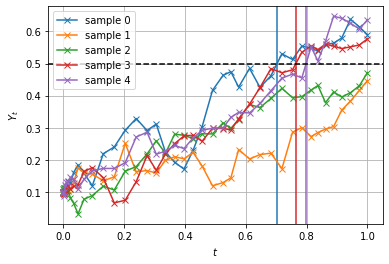

In [5]:
def plot(ts, samples, event, xlabel, ylabel, title=''):
    ts = ts.squeeze().t().cpu()
    samples = samples.squeeze().t().cpu()
    plt.figure(figsize=(6,4))
    for i, sample in enumerate(samples):
        l, = plt.plot(ts[i], sample, marker='x', label=f'sample {i}')
        
        for t, batch in event.triggered:
            if i == batch:
                plt.axvline(t.item(), color=l.get_c())
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()

plot(ts, ys, events[0], xlabel='$t$', ylabel='$Y_t$')
plt.axhline(0.5, c='black', linestyle='--')

This could for example be used to evaluate hitting times.

Of course, these could also be evaluated post-processing the data. But the structure of the event class can be modified to change more about the integration procedure during the integration. For example, the derivative functions f,g could be modified once a target point has been hit, or the solver step size adjusted.

The most prominent change is that of terminal events, which can terminate the evolution of single batches once triggered.

## Crossing a potential barrier and terminal events

In [6]:
a = 0.005
b = 1.

def V(x):
    return a*x**3 - b*x

def dV(x):
    return 3*a*x**2 - b

x_b = np.sqrt(b/3/a) # |barrier position|
x_0 = 0. # starting point

(-20.0, 20.0)

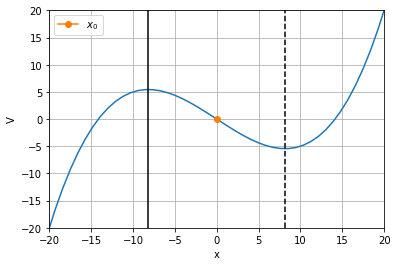

In [7]:
x_grid = np.linspace(-22, 22)
plt.plot(x_grid, V(x_grid))
plt.axvline(-x_b, color='black')
plt.axvline(x_b, color='black', linestyle='--')
plt.plot(x_0, V(x_0), marker='o', label="$x_0$")
plt.grid(); plt.legend()
plt.xlabel('x'); plt.xlim(-20, 20); plt.ylabel('V'); plt.ylim(-20, 20)

We consider a model where objects are moving inside a potential $V(x)$. The objects have a position $x$ and a velocity $v$., with $\frac{dx}{dt}=v$, and $\frac{dv}{dt}=-\frac{\partial V}{\partial x}(x)$. For the given starting point $x_0$ they would oscillate inside the potential forever. Adding some randomness to the velocity, they might cross the potential barrier. Here the model breaks down and the objects would accelerate to infinte speeds, breaking the numerical integration. For this purpose, the terminal events were implemented. They can termintae the evolution of a single batch without stopping the whole integration. 

In [8]:
class PotentialSDE(nn.Module):

    class BarrierCrossedEvent(torchsde.HitTargetEvent):
        
        def __init__(self):
            super().__init__(terminal=True) # set to terminal
        
        def target(self, t, y):
            return y - (-3./2.*x_b) # here we are well across the barrier
    
    def __init__(self):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
    
    def f(self, t, y):
        dy = torch.zeros(y.shape)
        dy[:,0] = y[:,1]  # dx/dt = v
        dy[:,1] = -dV(y[:,0]) # dv/dt = -dV/dx
        return dy
    
    def g(self, t, y):
        dW = torch.zeros(y.shape)
        dW[:,1] = y[:,1]/10. # randomness in the velocity
        return dW

In [9]:
batch_size, state_size = 3, 2
sde = PotentialSDE()
events = [PotentialSDE.BarrierCrossedEvent()]
tspan = [0., 200.]
y0 = torch.ones(size=(batch_size, state_size))
y0[:,0] *= x_0
y0[:,1] = 0.

with torch.no_grad():
    ts, ys, events = torchsde.solve_sde(sde, y0, tspan, events=events) 

In [10]:
print(ts.T)

tensor([[0.0000e+00, 1.0000e-03, 2.4000e-03,  ..., 3.3866e+01, 3.3866e+01,
         3.3866e+01],
        [0.0000e+00, 1.0000e-03, 2.4000e-03,  ..., 9.3127e+01, 9.3127e+01,
         9.3127e+01],
        [0.0000e+00, 1.0000e-03, 2.4000e-03,  ..., 1.4727e+02, 1.4738e+02,
         1.4746e+02]])


Once a branch is terminated, the last values of t, y are added repeatedly to the tensor to keep a rectangular structure, but the functions f,g are not called anymore for these values.

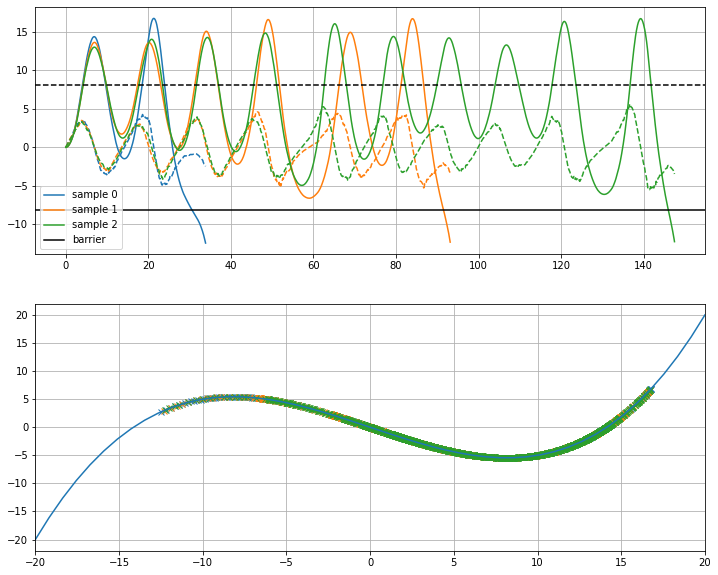

In [11]:
def plot_in_potential(ts, samples, event, V, ax_t, ax_V):
    
    for batch in range(samples.shape[1]):
        t = np.unique(np.array(ts[:,batch])) # remove the repeating values
        x = np.array(samples[:len(t), batch, 0]) # now we can take the values up until that array position
        v = np.array(samples[:len(t), batch, 1]) 
        
        l, = ax_t.plot(t, x, label=f'sample {batch}')
        ax_t.plot(t, v, color=l.get_c(), linestyle='--')
        ax_V.plot(x, V(x), marker='x', color=l.get_c())
        

fig, axs = plt.subplots(2, figsize=(12,10))
plot_in_potential(ts, ys, events, V, axs[0], axs[1])

axs[0].axhline(x_b, color='black', linestyle='--')
axs[0].axhline(-x_b, color='black', label='barrier')
axs[0].legend()

x_grid = np.linspace(-20, 20)
axs[1].plot(x_grid, V(x_grid)); axs[1].set_xlim(-20, 20)
for ax in axs:
    ax.grid()


Here, it can be seen that the objects oscillate in the potential for a while and some of them cross the barrier. At this point the evolution is terminated. For many objects one could do statistics for the crossing time etc.